In [23]:
import requests
import pandas as pd
import numpy as np
from io import StringIO, BytesIO
import json
import geopandas as gpd
import matplotlib.pyplot as plt

np.random.seed(7)

RTA_ROUTE_URL = 'https://opendata.arcgis.com/datasets/1cb5c63d6f114f8a94c6d5a0e03ae62e_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'
RTA_ROUTE_DATA = requests.get(RTA_ROUTE_URL)

RTA_STOPS_URL = 'https://gis.massdot.state.ma.us/arcgis/rest/services/Multimodal/RTAs/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json'
RTA_STOPS_DATA = requests.get(RTA_STOPS_URL)

RTA_RIDERSHIP_URL = 'https://www.transit.dot.gov/sites/fta.dot.gov/files/2020-10/August%202020%20Adjusted%20Database.xlsx'
RTA_RIDERSHIP_DATA = requests.get(RTA_RIDERSHIP_URL)

# Rishab helper code
def add_census_tract(dataframe):
    polygons = gpd.read_file("../data/tl_2019_25_tract.shp")
    polygons = polygons.rename(columns={"TRACTCE": "census_tract"}, index=str)
    polygons = polygons.to_crs("EPSG:26986")
    gdf = dataframe
    df = gpd.sjoin(gdf, polygons[['census_tract', 'geometry']], how='left', op='within')
    df.drop(columns=['index_right'], inplace=True)
    return df


def get_median_hh_income():
    '''
    Returns Pandas DataFrame representation Median Household Income Estimate by Census Tract for MA.
    American Community Survey (ACS) 2018 Census data used.
    Specific table: ACS 2018 5-year detailed table "B19013_001E"
    '''
    URL = "https://api.census.gov/data/2018/acs/acs5?get=B19013_001E&for=tract:*&in=state:25"

    response = requests.get(url = URL)
    data = response.json()

    median_income_df = pd.DataFrame(data[1:len(data)-1], columns = data[0])

    return median_income_df

In [24]:
# Transit Datasets
route_df = pd.read_csv(StringIO(RTA_ROUTE_DATA.content.decode()))
stops_data = json.loads(RTA_STOPS_DATA.content)['features']
ridership_df = pd.read_excel(BytesIO(RTA_RIDERSHIP_DATA.content), sheet_name='MASTER')

# TODO: Verify this has all the MA rta's
ma_riders = ridership_df.loc[ridership_df['UZA Name'].str.contains(', MA')]
ma_riders = ma_riders.loc[ma_riders['Agency'] != 'Massachusetts Bay Transportation Authority']

agency_set = list(set([stop['attributes']['Agency'] for stop in stops_data]))
print(agency_set)


['SoutheasternRTA', 'MetroWestRTA', 'CapeCodRTA', 'VineyardRTA', 'MontachusettRTA', 'LowellRTA', 'GATRA_RTA', 'BerkshireRTA', 'WRTA', 'NantucketRTA', 'BrocktonAreaRTA', 'MerrimackValleyRTA', 'CapeAnnRTA', 'FranklinRTA', 'PioneerValleyRTA']


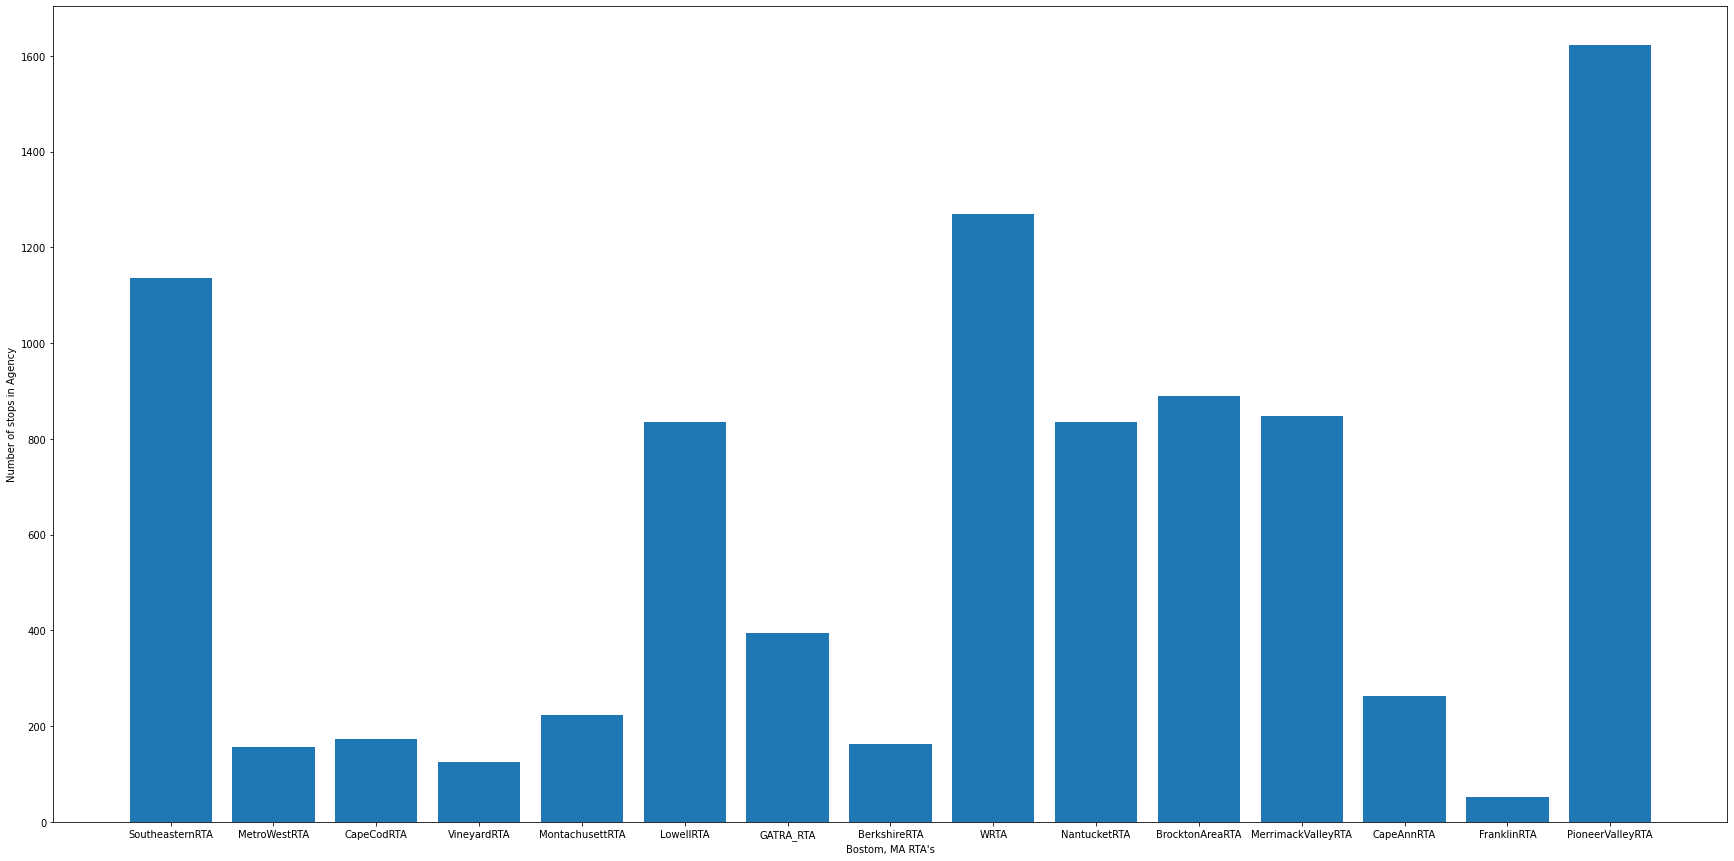

In [25]:
# Generate Bar graph of stops
num_stops = [0 for agency in agency_set]
for stop in stops_data:
    num_stops[agency_set.index(stop['attributes']['Agency'])] += 1

fig = plt.figure(figsize=(30,15))
plt.bar(agency_set, num_stops)
plt.xlabel("Bostom, MA RTA's")
plt.ylabel("Number of stops in Agency")
plt.show()

In [26]:
# Display fare income per area
agency_fares = ma_riders[['Agency']].drop_duplicates()
agency_fares[['total fare']] = agency_fares.apply(
    lambda x: ma_riders.loc[ma_riders['Agency'] == x['Agency']][['Fares FY']].sum(), 
    axis=1
)

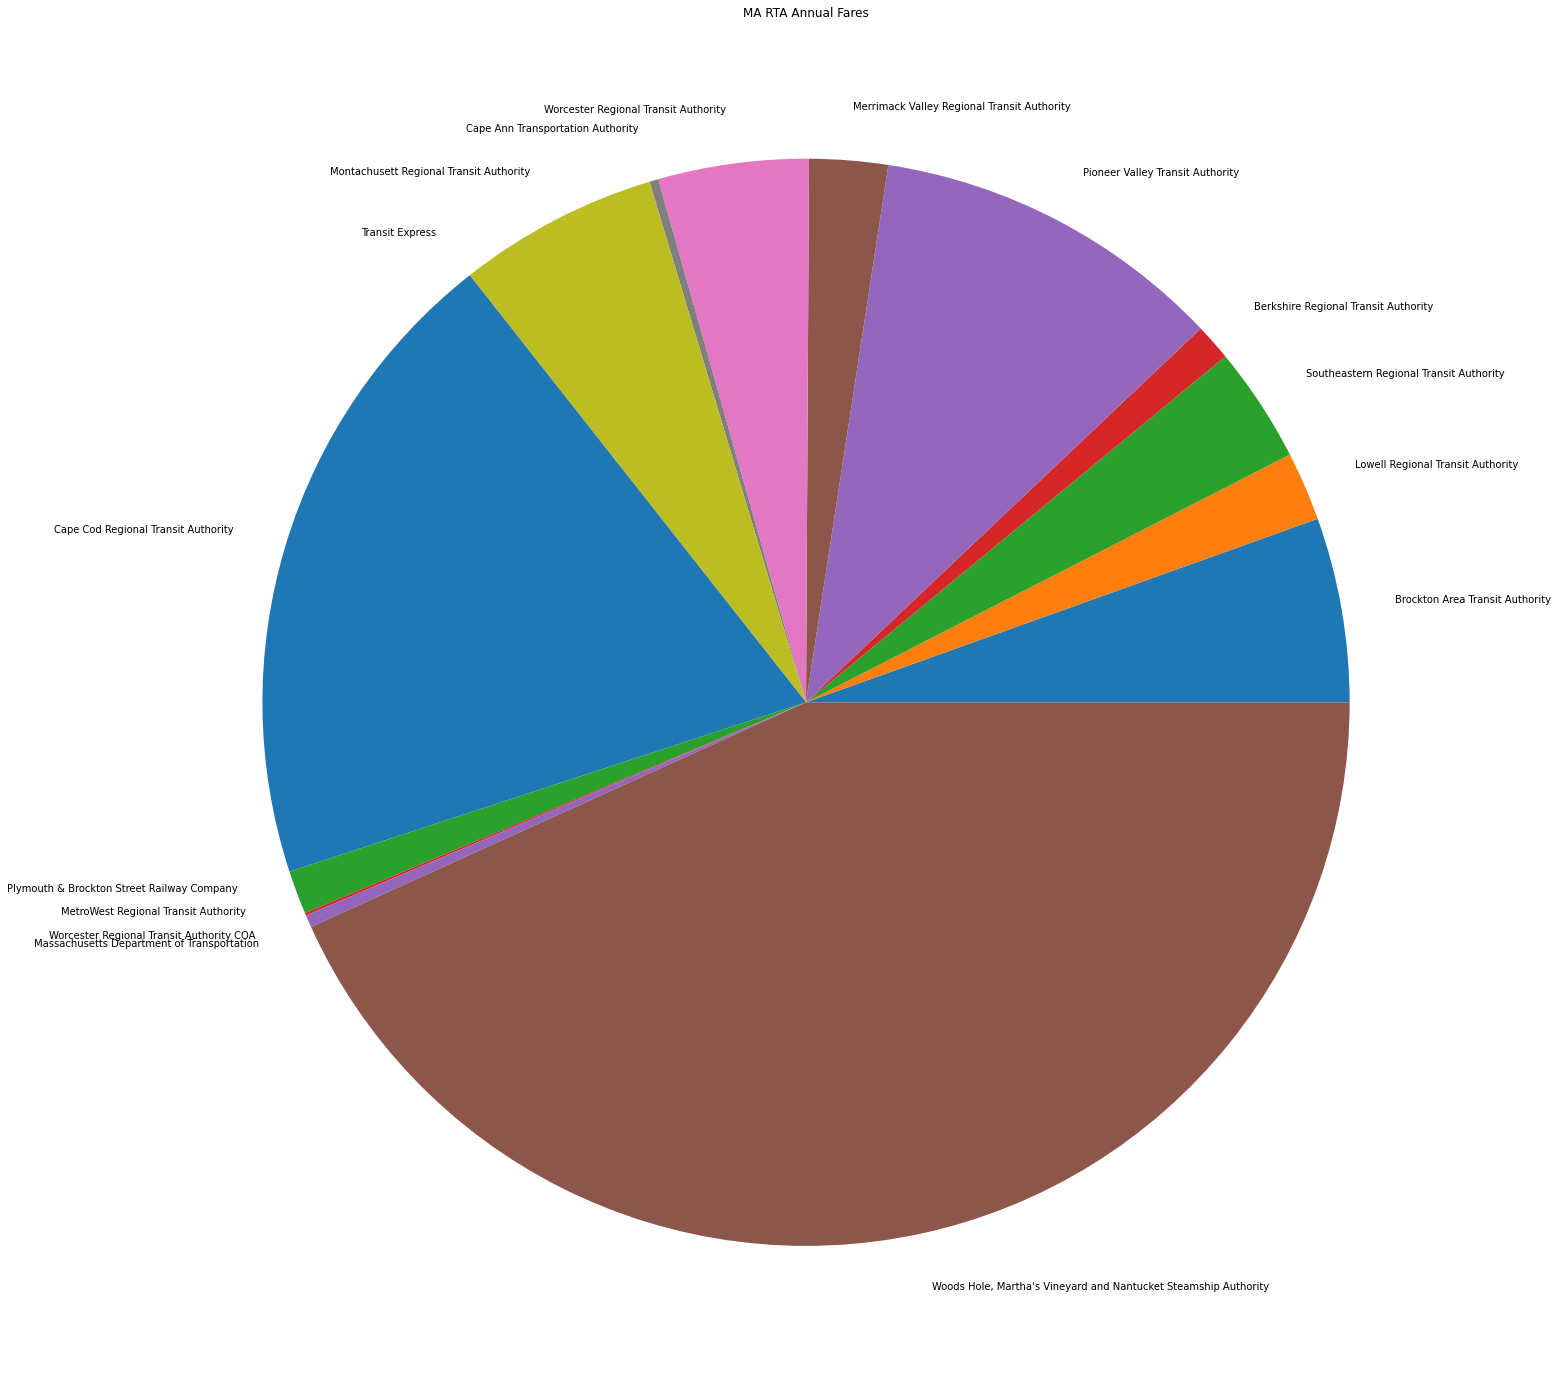

In [27]:
fig = plt.figure(figsize=(50,25))
plt.pie(agency_fares[['total fare']].to_numpy().flatten().astype(int), labels=agency_fares[['Agency']].to_numpy().flatten())
plt.title('MA RTA Annual Fares')
plt.show()

In [28]:
# Get only brockton
brockton = {
    'routes': route_df.loc[route_df['Agency'] == 'BrocktonAreaRTA'],
    'ridership': ridership_df.loc[ridership_df['Agency'] == 'Brockton Area Transit Authority'],
    'stops': [stop for stop in stops_data if stop['attributes']['Agency'] == 'BrocktonAreaRTA']
}

In [30]:
stops_data_parsed = []
for stop in stops_data:
    stop_reformatted = {}
    stop_reformatted['geometry'] = stop['geometry']
    for key in stop['attributes']:
        stop_reformatted[key] = stop['attributes'][key]
    stops_data_parsed.append(stop_reformatted)
gdf = gpd.GeoDataFrame(stops_data_parsed)
# try:
#     add_census_tract(gdf)
# except:
#     print("Couldn't add census tract :)")

HI
